### Setup Environment:

In [1]:
from src.get_dataset import split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'patient_sex'
TEST_SIZE = 0.7
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_base'
MODE = 'fine_tune'
backbone_mode = 'eval'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 5e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df_train = pd.read_csv(os.path.join(DATASET, 'train_ssl.csv'))
df_test = pd.read_csv(os.path.join(DATASET, 'test_ssl.csv'))

In [4]:
# Map values to categories
df_train[LABEL] = df_train[LABEL].apply(lambda x: 'Male' if x == 1 else 'Female')
df_test[LABEL] = df_train[LABEL].apply(lambda x: 'Male' if x == 1 else 'Female')

Getting validation set...
Train data shape: (5205, 35)
Test data shape: (1302, 35)


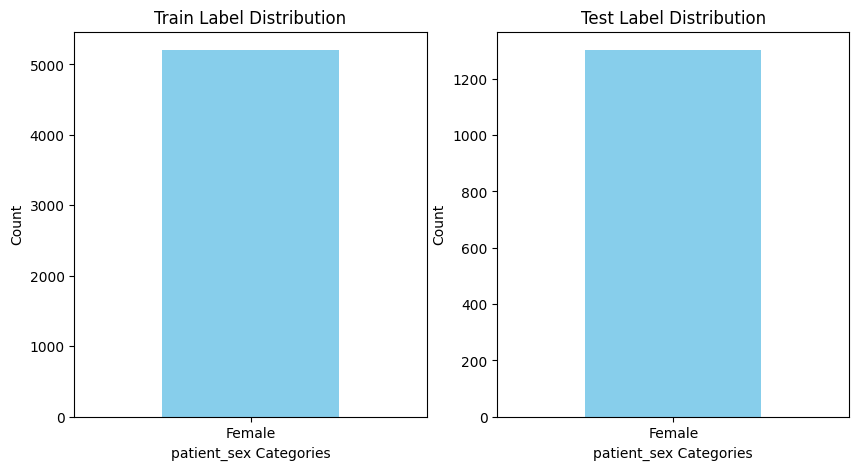

In [5]:
# Split dataset into train, test and validation:
#df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

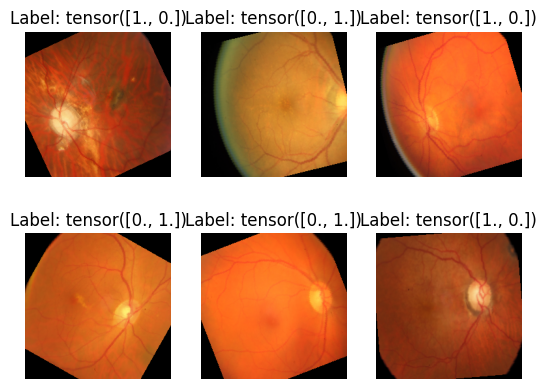

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
# Load backbone weights:
backbone_model.load_state_dict(torch.load('Models/checkpoint_convnextv2_base_byol.pt'))
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'convnextv2_binary_{LABEL}_byol')

100%|██████████| 82/82 [00:23<00:00,  3.44it/s]


Epoch 1, Train Loss: 0.7210066988819935, Val Loss: 0.6903632443125655, F1 Score: 0.40710382513661203


100%|██████████| 82/82 [00:23<00:00,  3.42it/s]


Epoch 2, Train Loss: 0.7004913232854155, Val Loss: 0.6699844685996451, F1 Score: 0.43563068920676207


100%|██████████| 82/82 [00:23<00:00,  3.48it/s]


Epoch 3, Train Loss: 0.6719581146709255, Val Loss: 0.7377196717553023, F1 Score: 0.39722222222222225


100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Epoch 4, Train Loss: 0.6352811594478419, Val Loss: 0.46094615466711, F1 Score: 0.4590776900706273


100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Epoch 5, Train Loss: 0.5962901170625061, Val Loss: 0.9580201077751997, F1 Score: 0.29659643435980554


100%|██████████| 82/82 [00:23<00:00,  3.51it/s]


Epoch 6, Train Loss: 0.5710479243856962, Val Loss: 1.298249999924404, F1 Score: 0.2770682953914492


100%|██████████| 82/82 [00:23<00:00,  3.51it/s]


Epoch 7, Train Loss: 0.5563804955267515, Val Loss: 1.2327164585997419, F1 Score: 0.2889131622064446


100%|██████████| 82/82 [00:24<00:00,  3.41it/s]


Epoch 8, Train Loss: 0.538651796735701, Val Loss: 1.1397335769199743, F1 Score: 0.30670926517571884


100%|██████████| 82/82 [00:23<00:00,  3.48it/s]


Epoch 9, Train Loss: 0.526106263648291, Val Loss: 0.8824545504843316, F1 Score: 0.3502994011976048


100%|██████████| 82/82 [00:23<00:00,  3.51it/s]


Epoch 10, Train Loss: 0.5084682648054889, Val Loss: 1.9688949882984161, F1 Score: 0.1997541487400123


100%|██████████| 82/82 [00:23<00:00,  3.46it/s]


Epoch 11, Train Loss: 0.4992834211128657, Val Loss: 1.1070161221957788, F1 Score: 0.3299022130725682
Early stopping triggered.


### Test

100%|██████████| 326/326 [01:31<00:00,  3.56it/s]


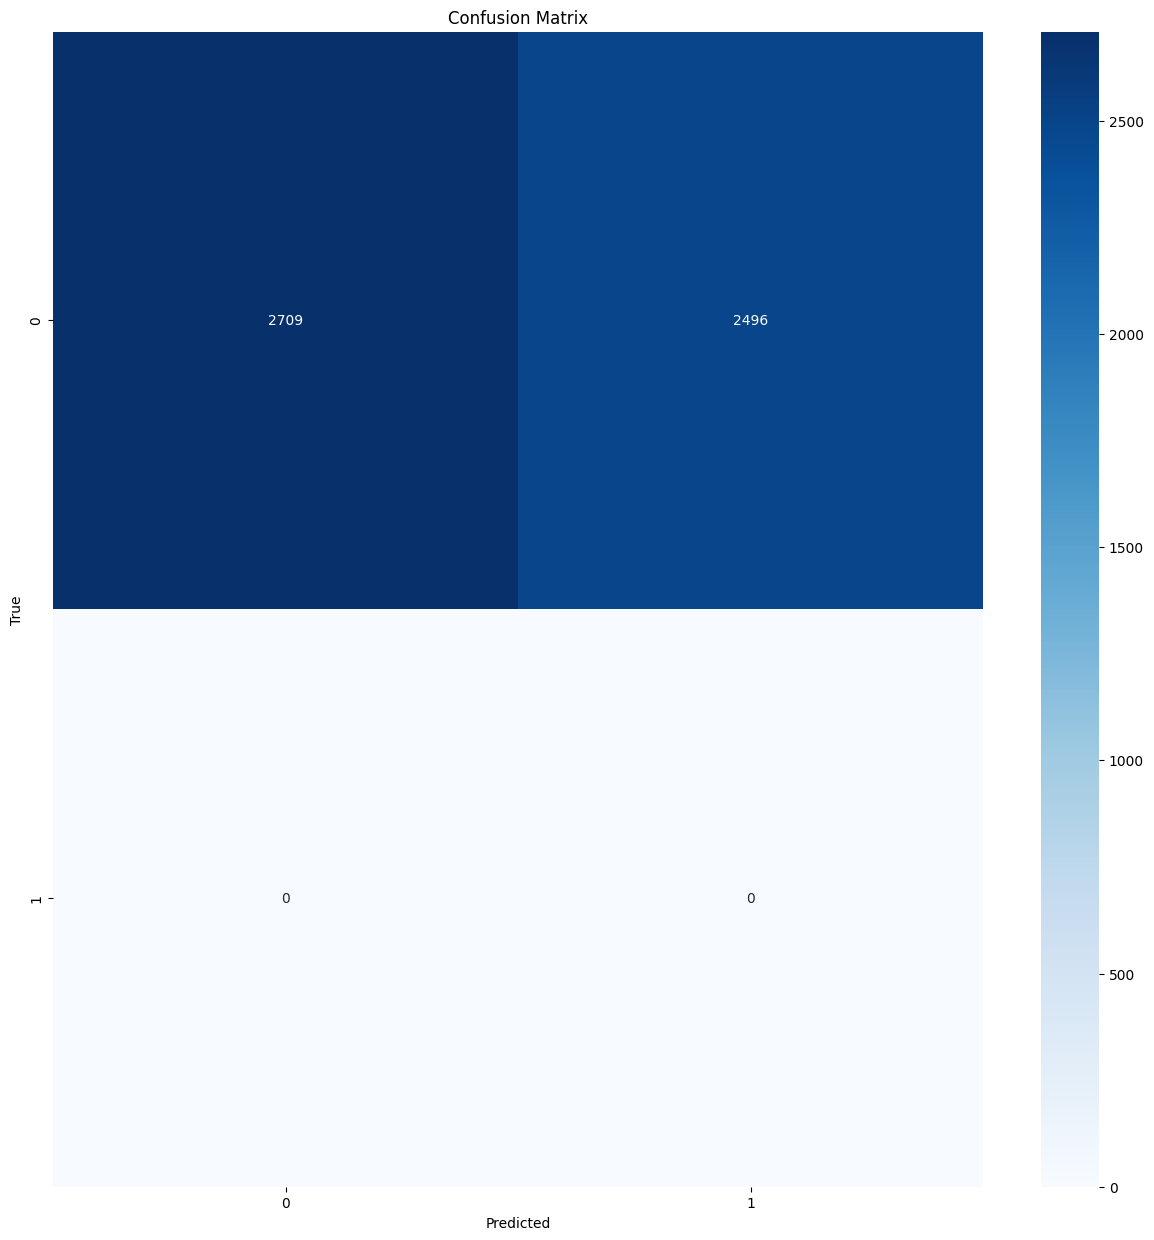

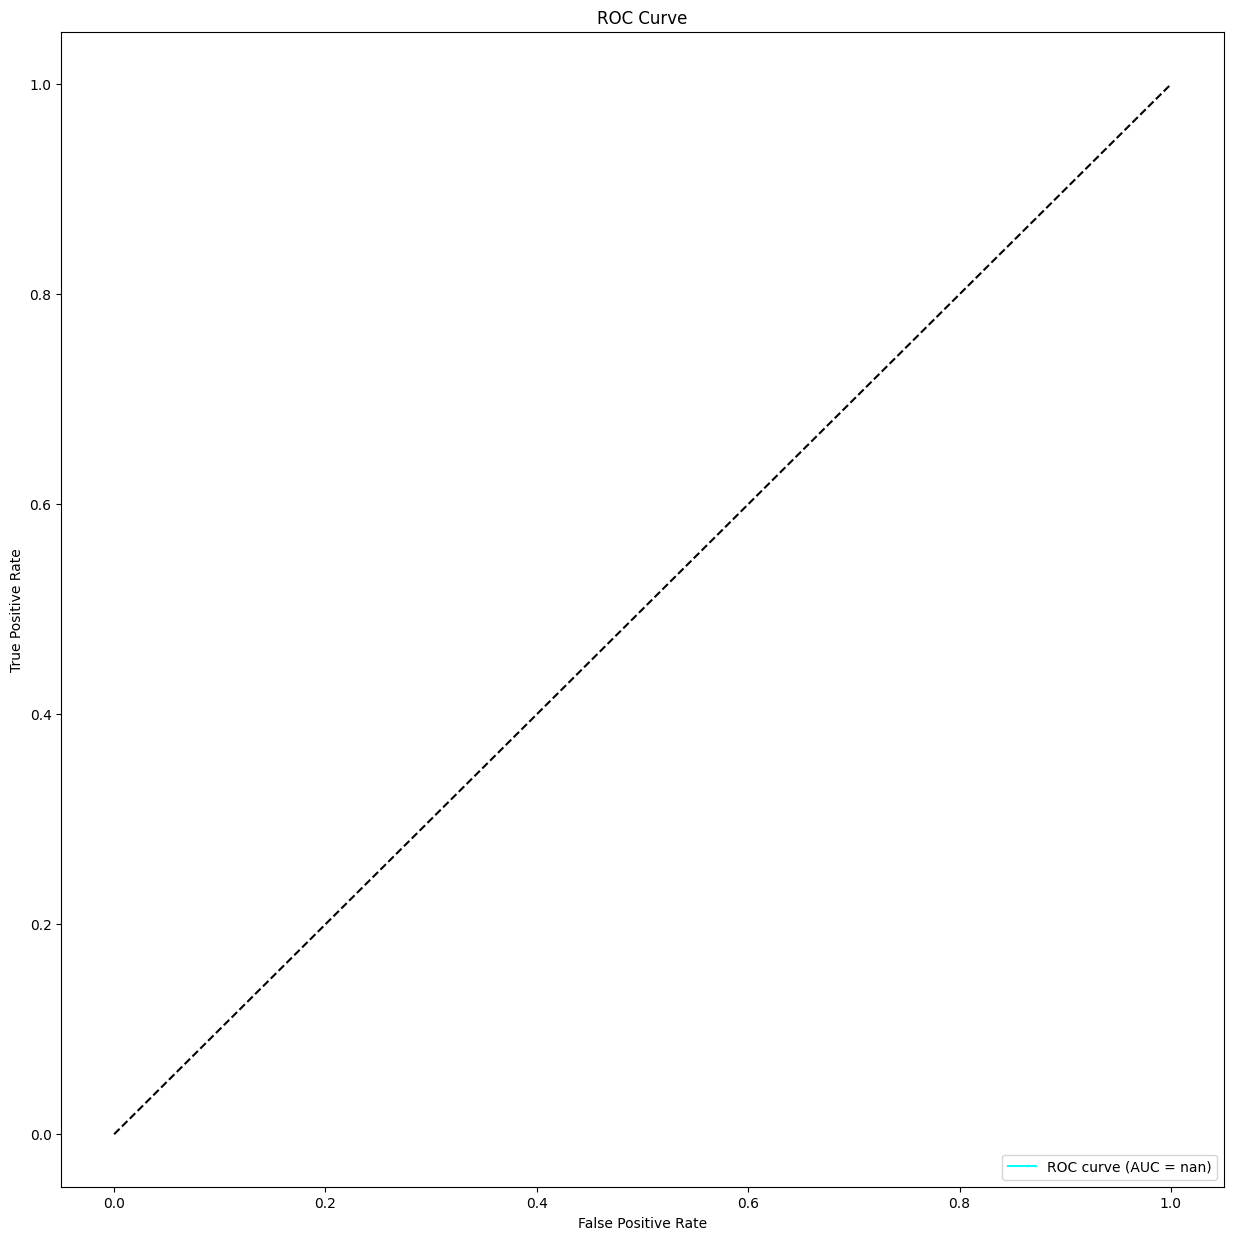

              precision    recall  f1-score   support

           0       1.00      0.52      0.68      5205
           1       0.00      0.00      0.00         0

    accuracy                           0.52      5205
   macro avg       0.50      0.26      0.34      5205
weighted avg       1.00      0.52      0.68      5205

##################################################  Saliency Maps  ##################################################

Class 0:


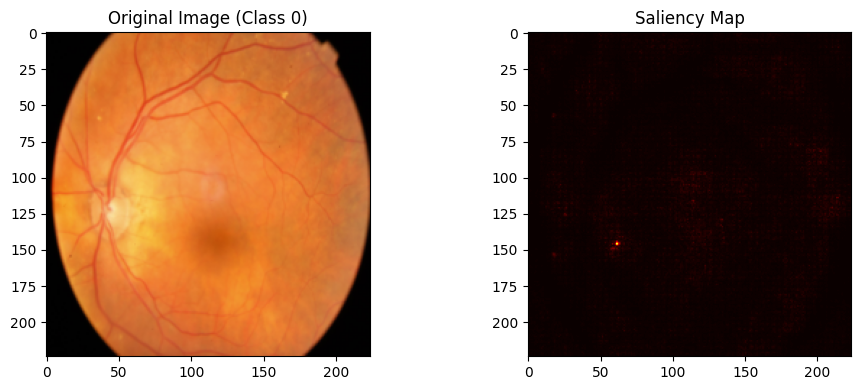

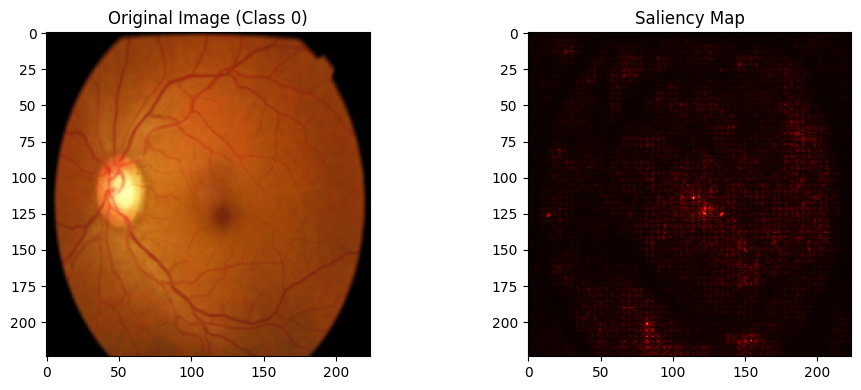

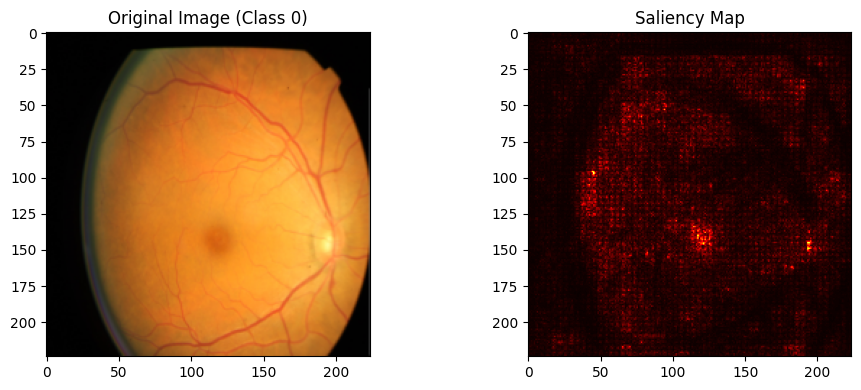

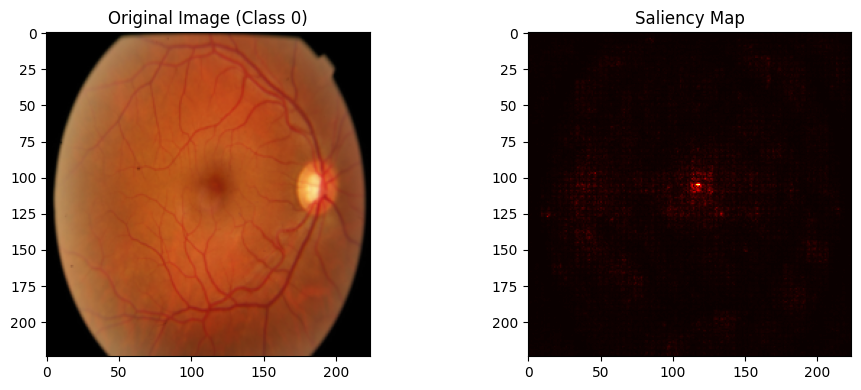

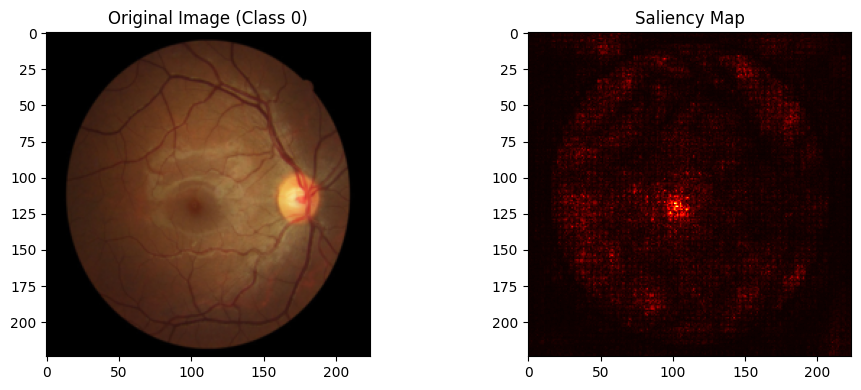

Class 1:


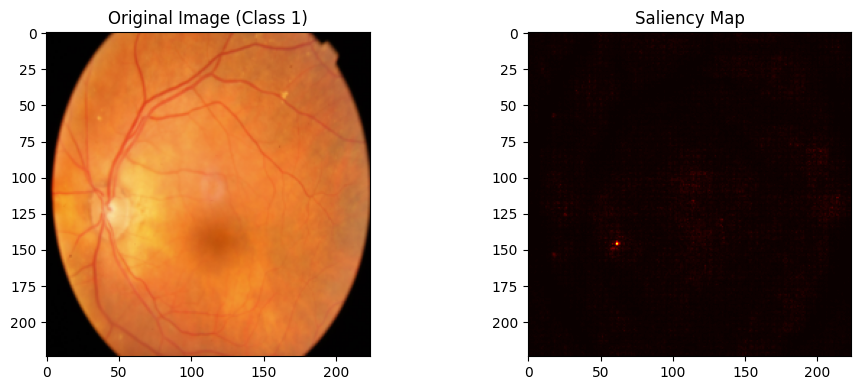

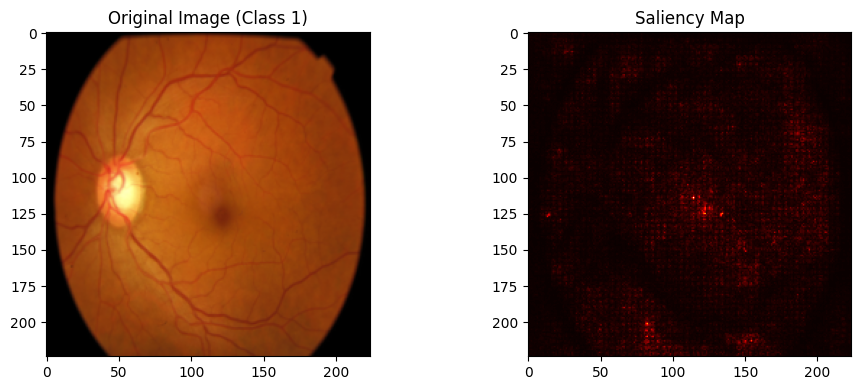

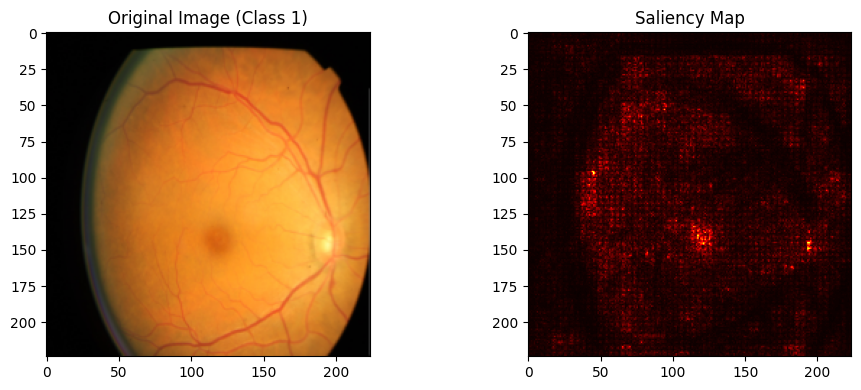

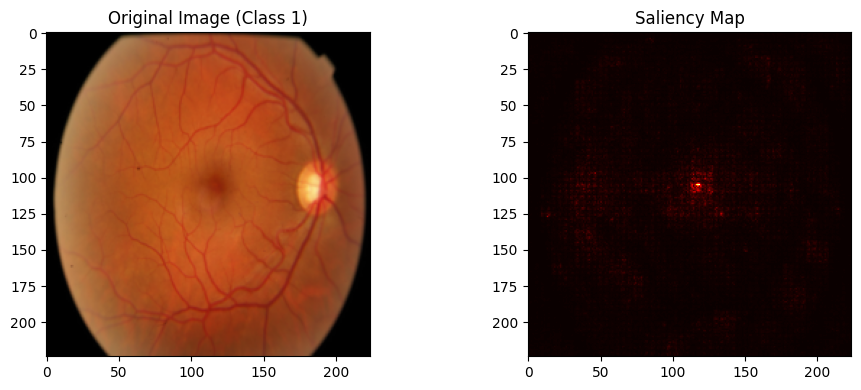

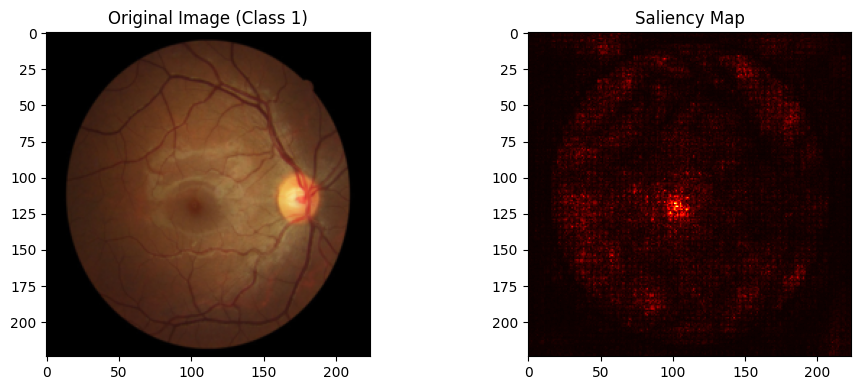

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 287/287 [01:20<00:00,  3.56it/s]


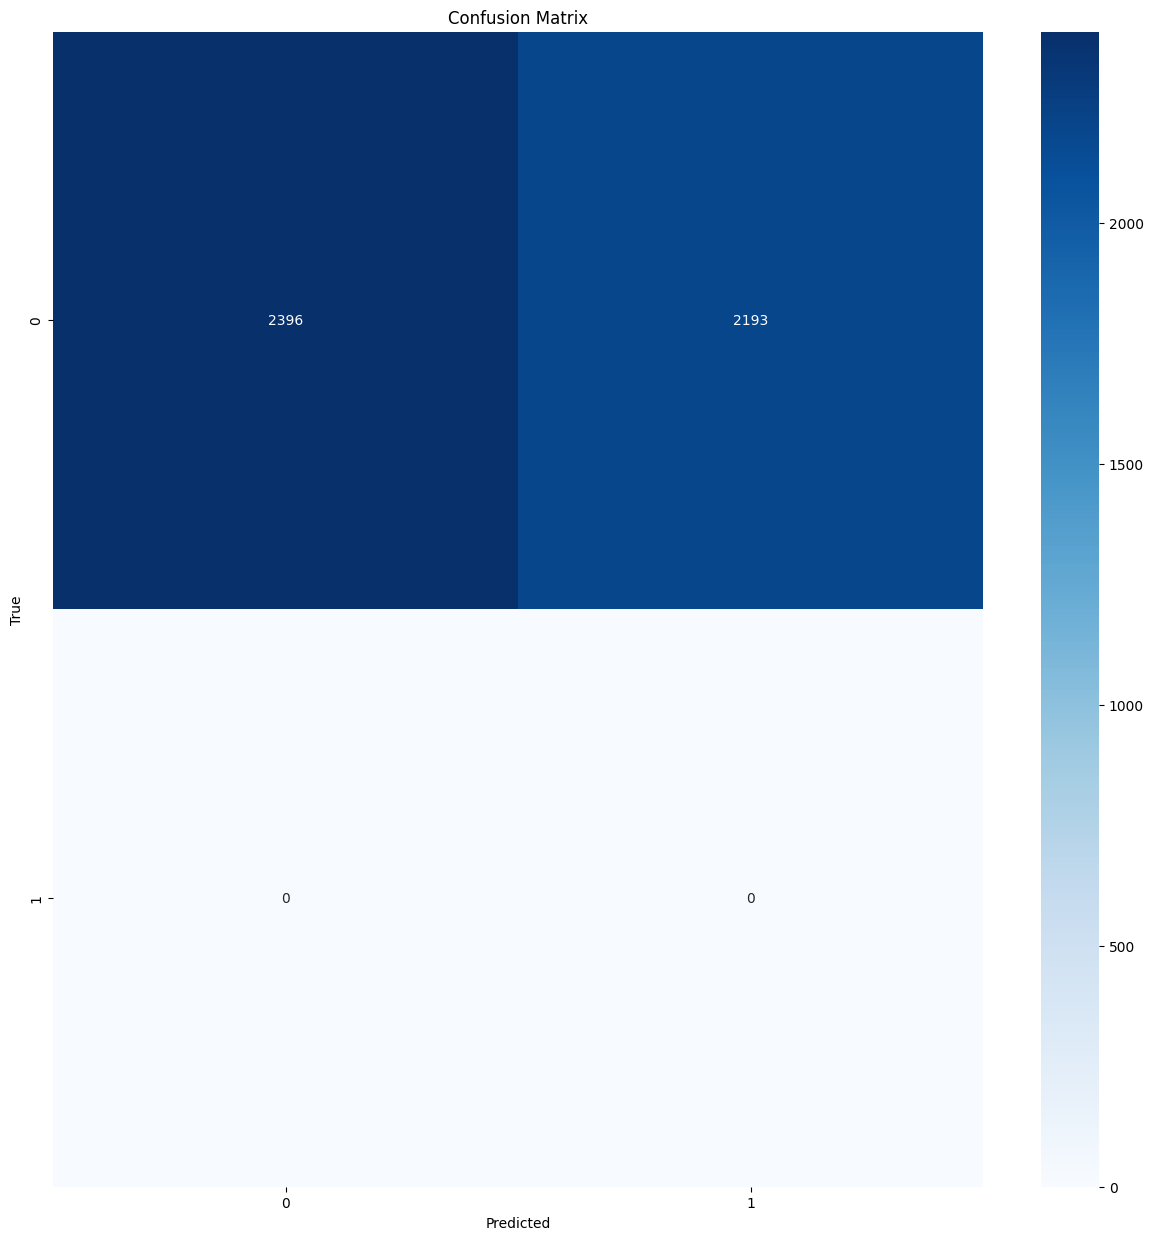

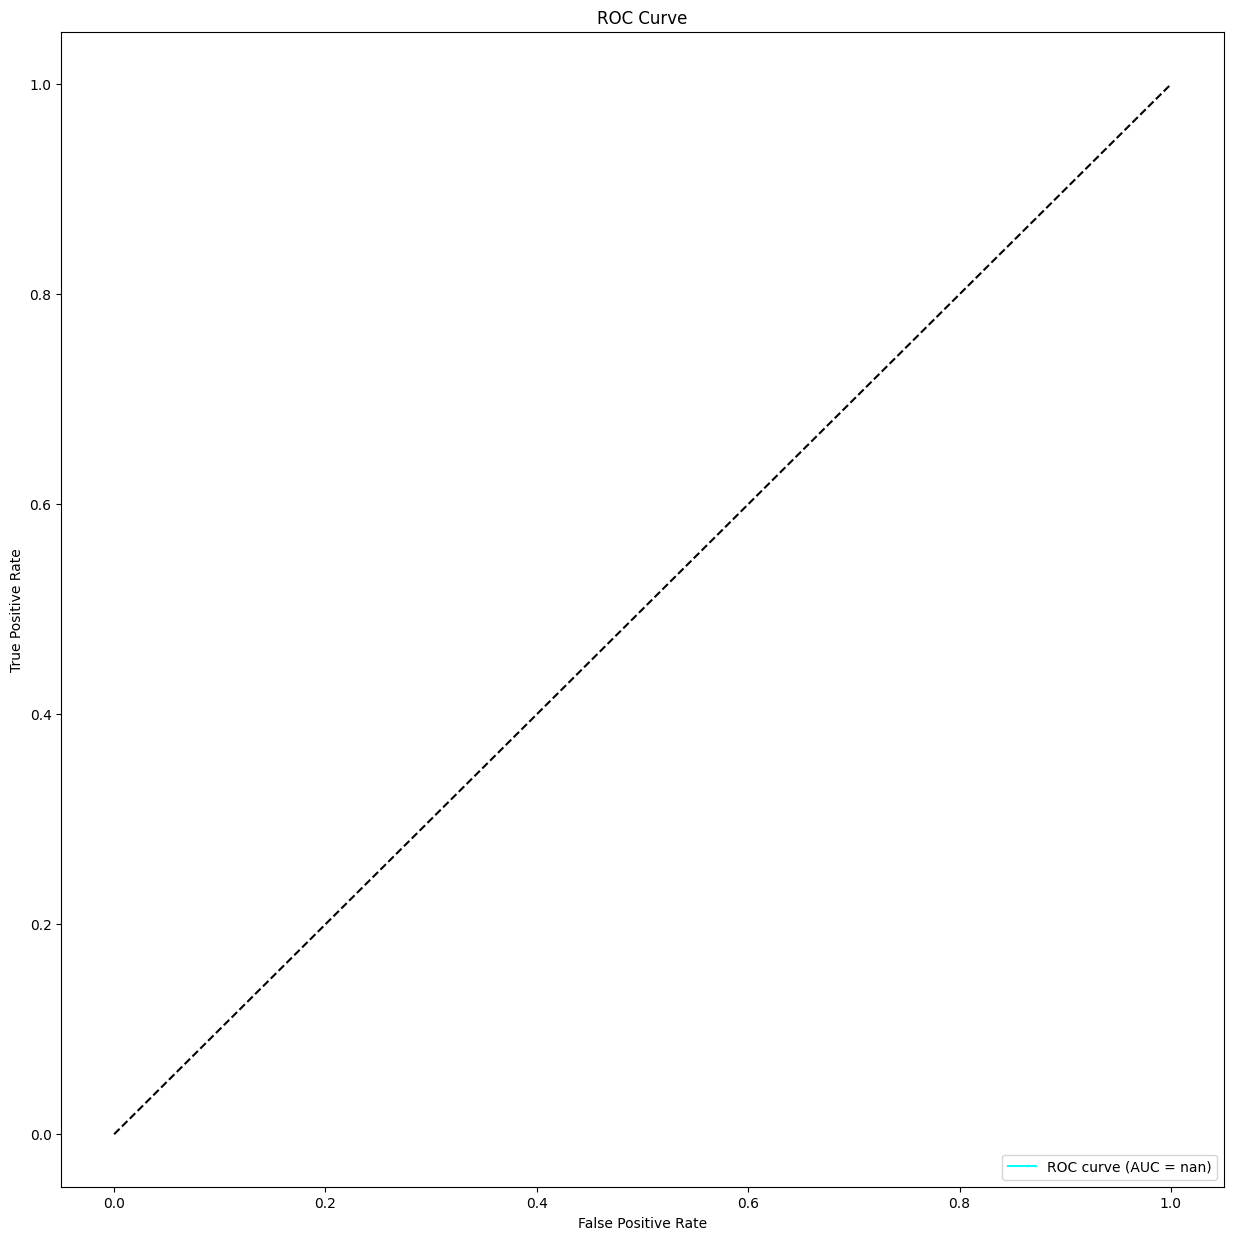

              precision    recall  f1-score   support

           0       1.00      0.52      0.69      4589
           1       0.00      0.00      0.00         0

    accuracy                           0.52      4589
   macro avg       0.50      0.26      0.34      4589
weighted avg       1.00      0.52      0.69      4589

##################################################  Saliency Maps  ##################################################

Class 0:


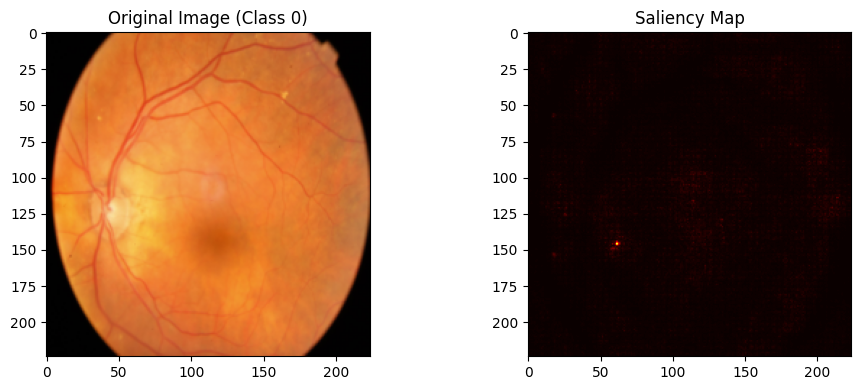

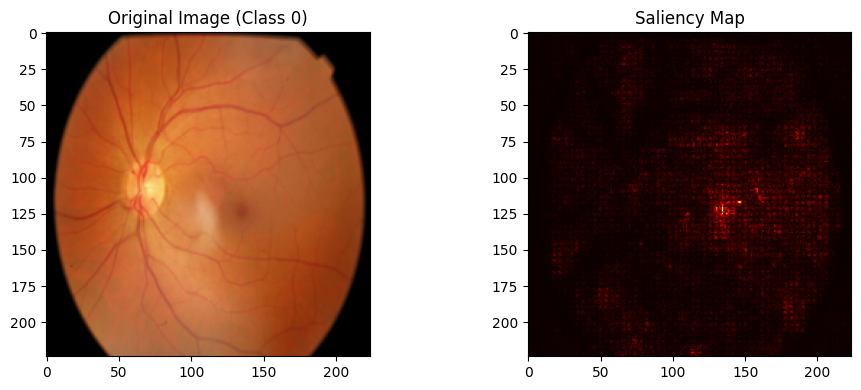

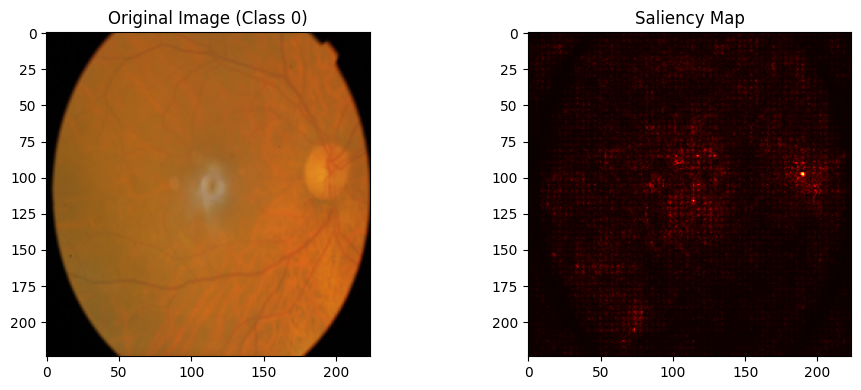

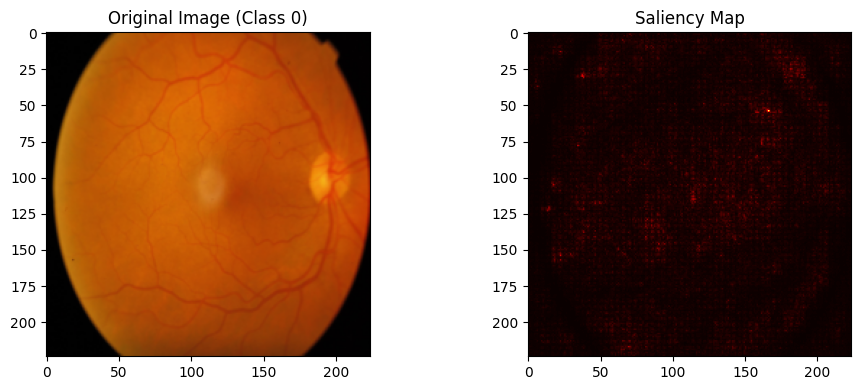

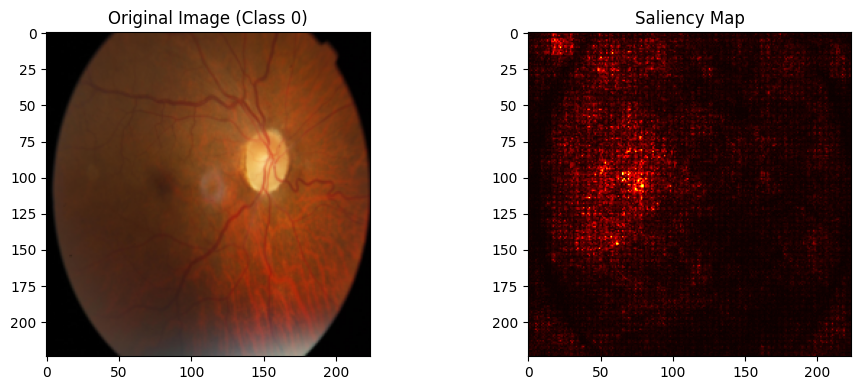

Class 1:


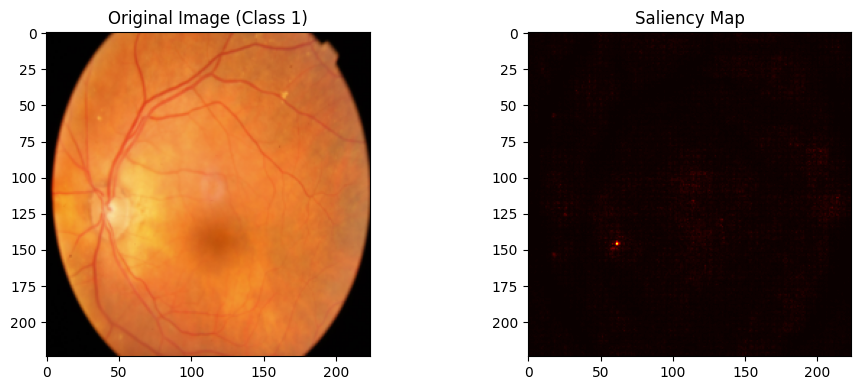

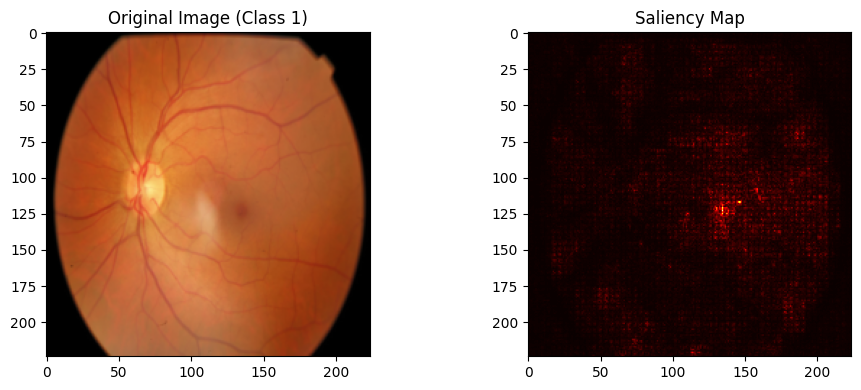

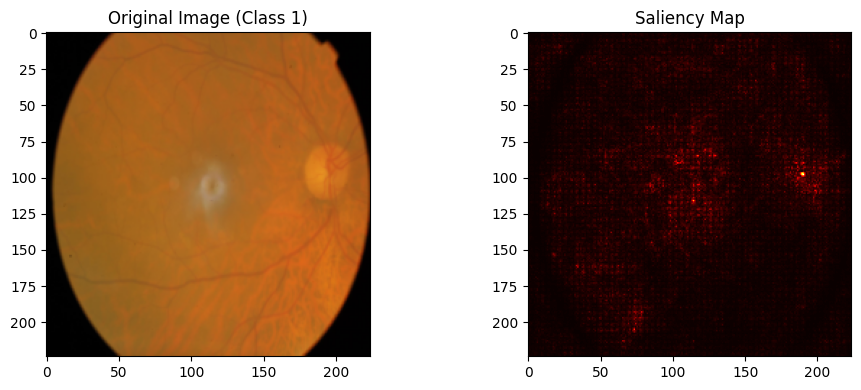

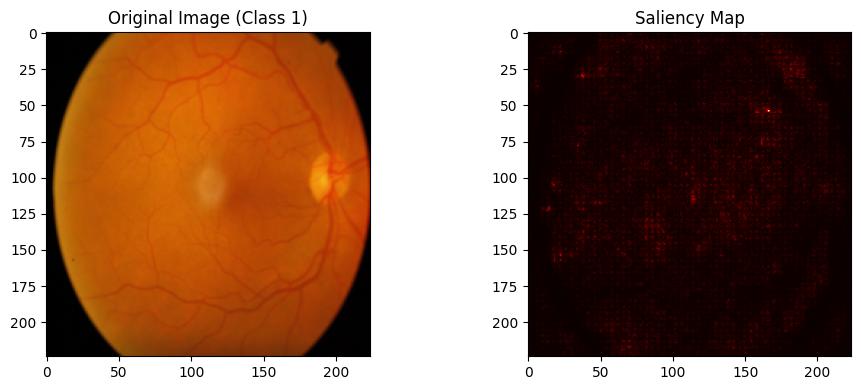

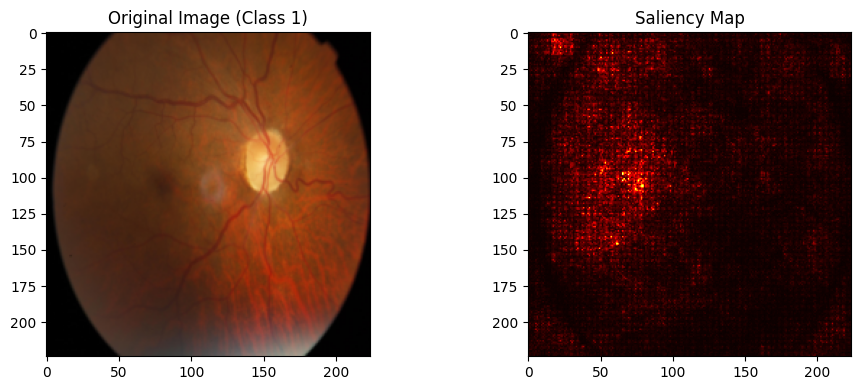

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 39/39 [00:12<00:00,  3.19it/s]


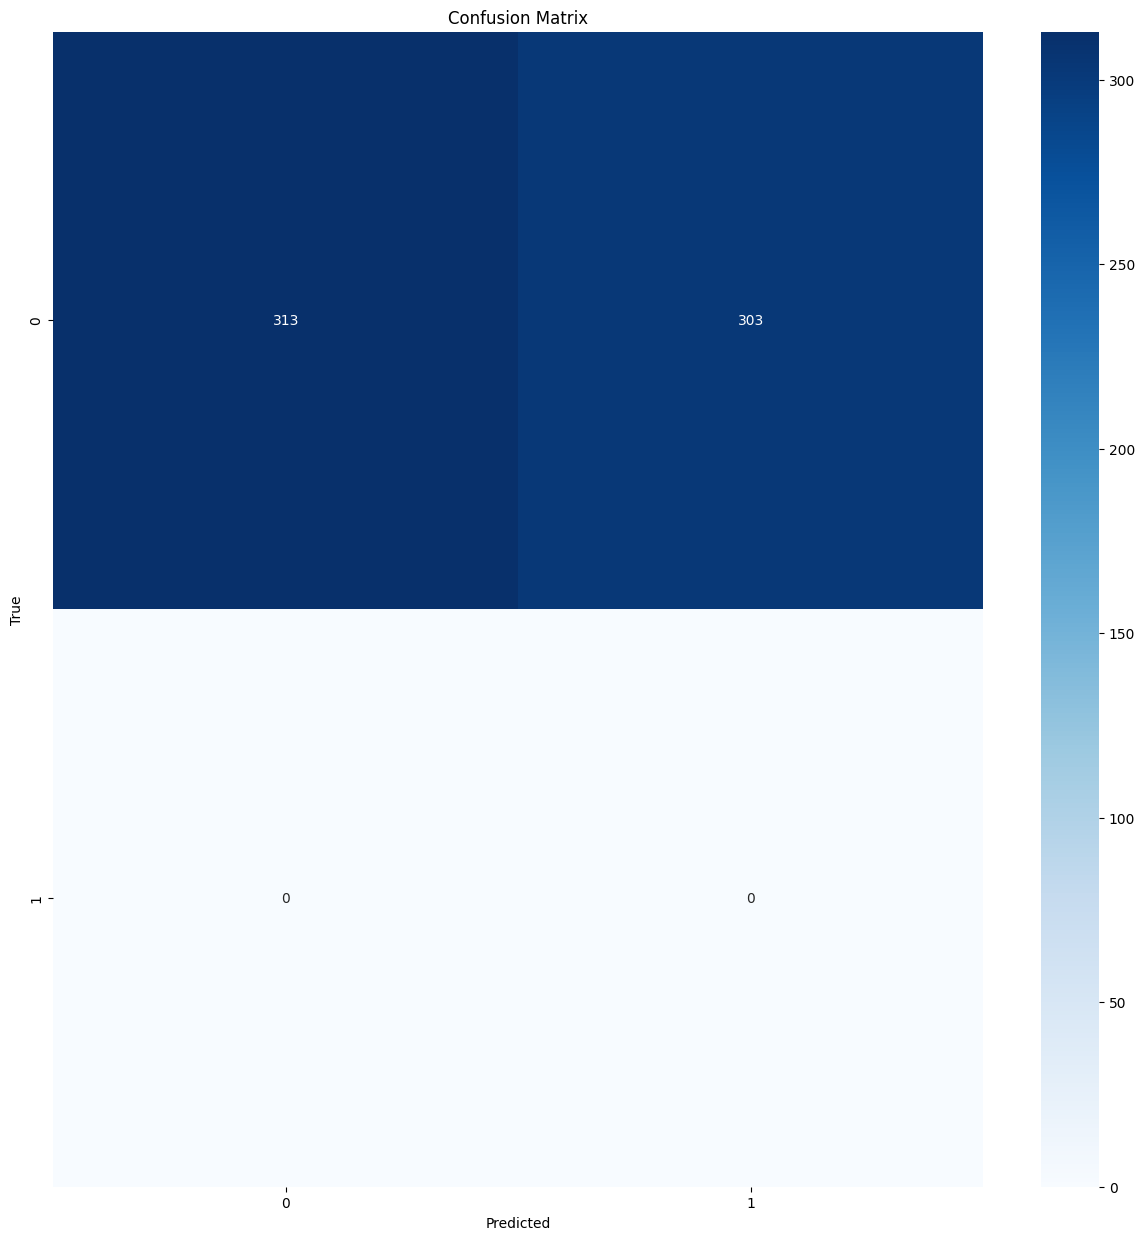

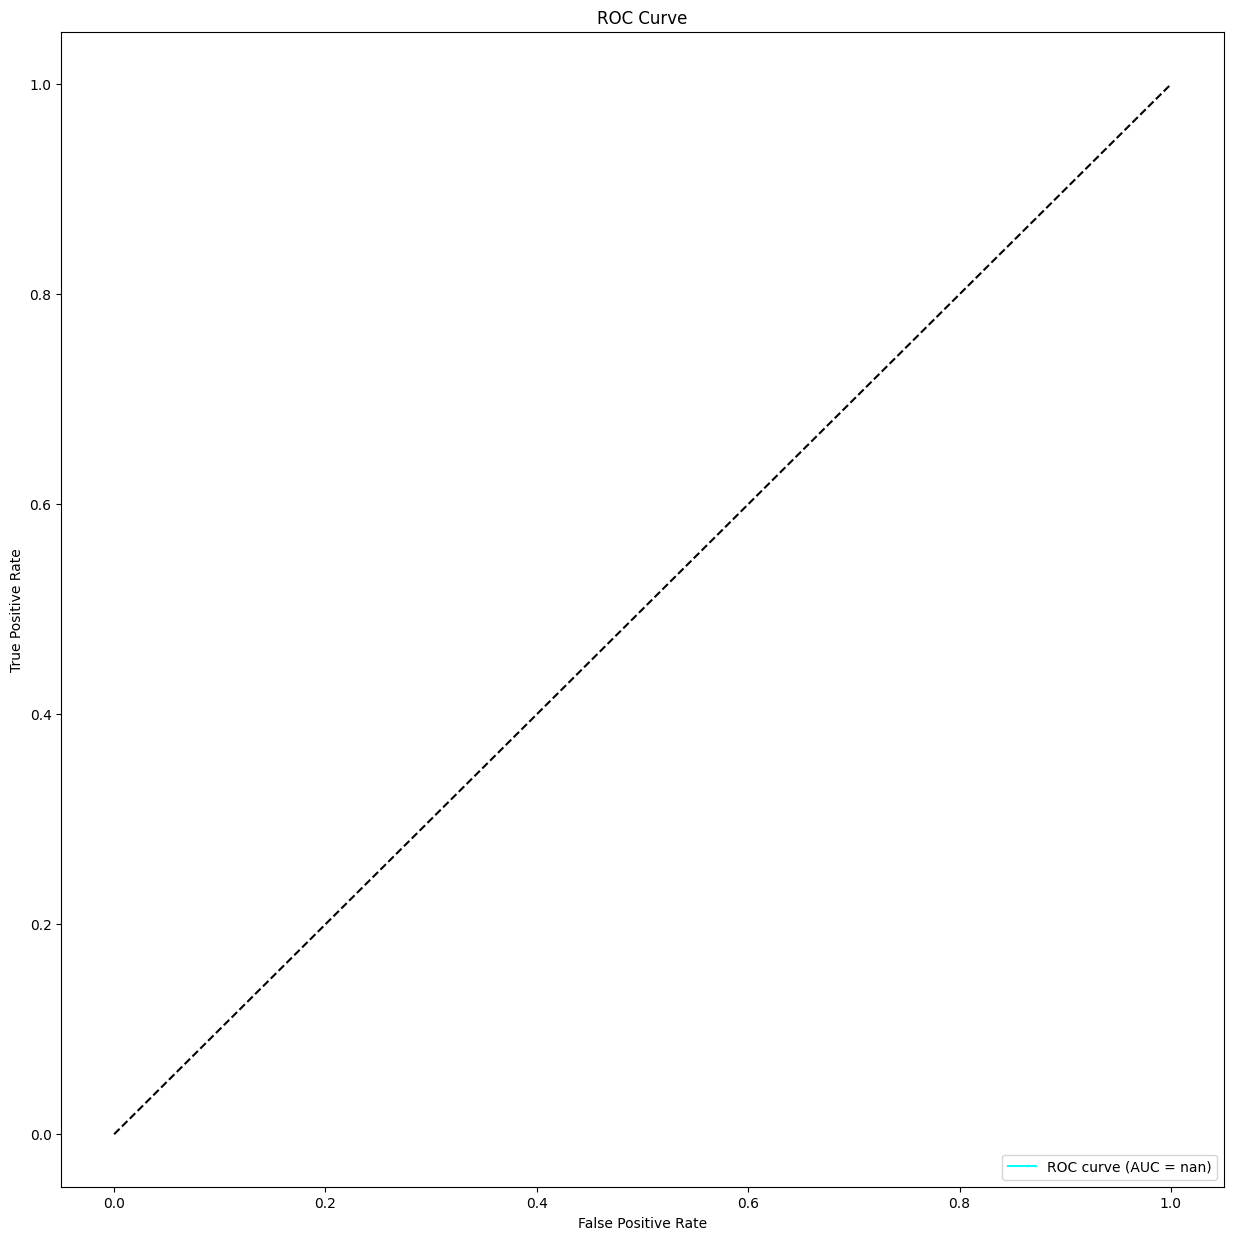

              precision    recall  f1-score   support

           0       1.00      0.51      0.67       616
           1       0.00      0.00      0.00         0

    accuracy                           0.51       616
   macro avg       0.50      0.25      0.34       616
weighted avg       1.00      0.51      0.67       616

##################################################  Saliency Maps  ##################################################

Class 0:


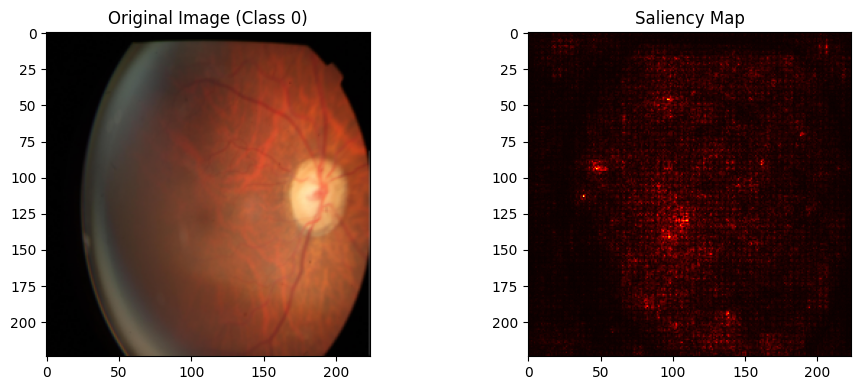

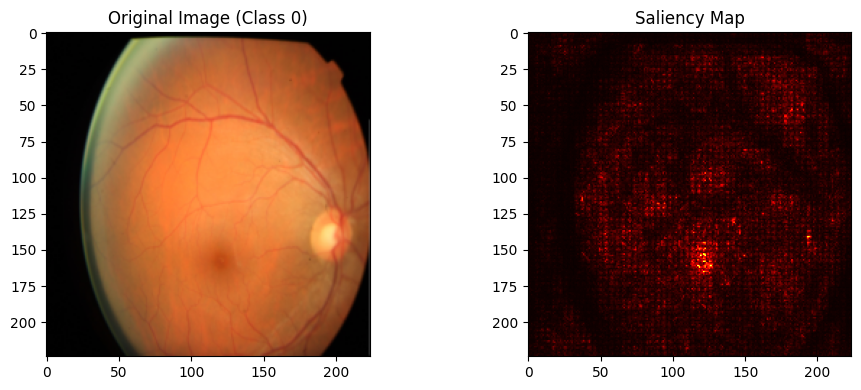

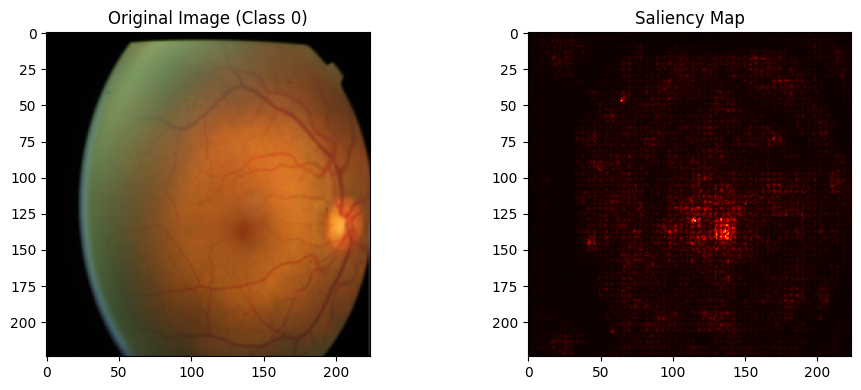

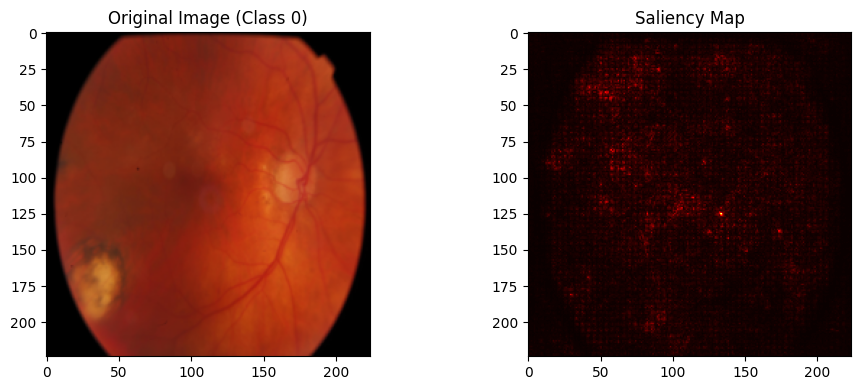

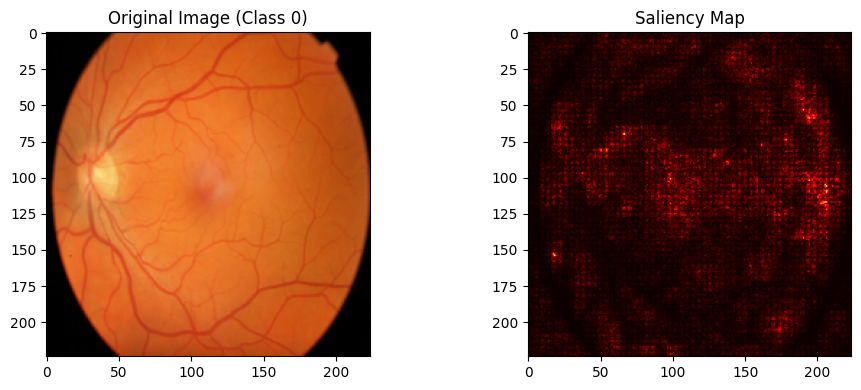

Class 1:


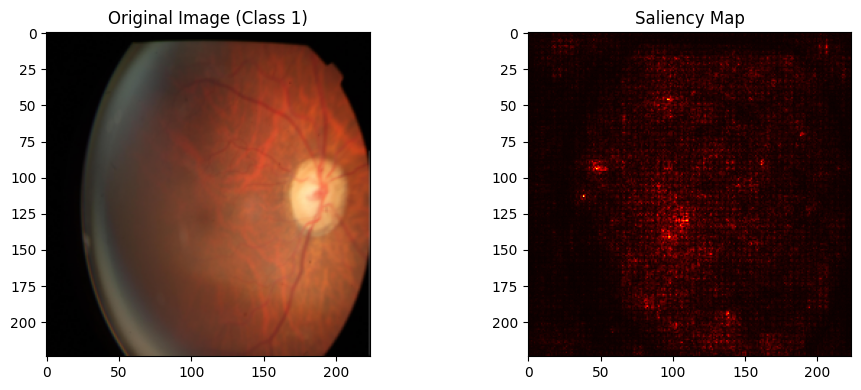

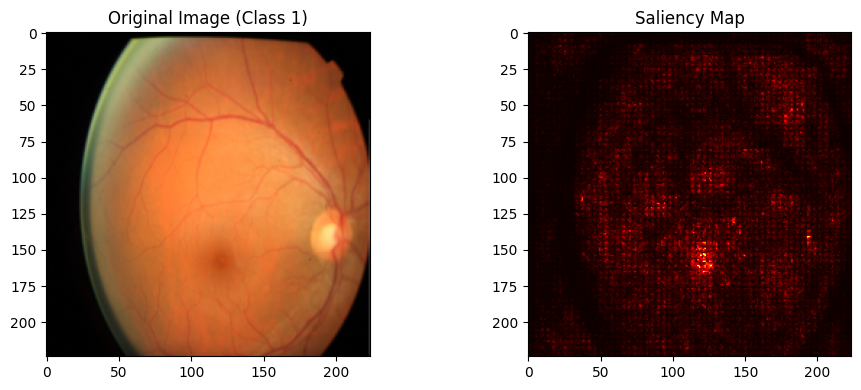

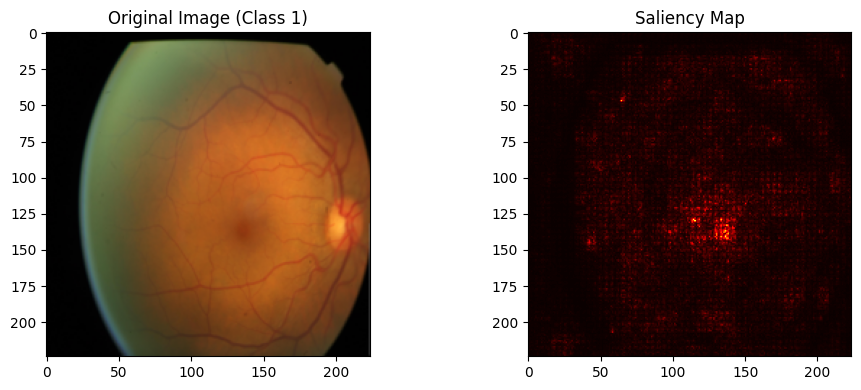

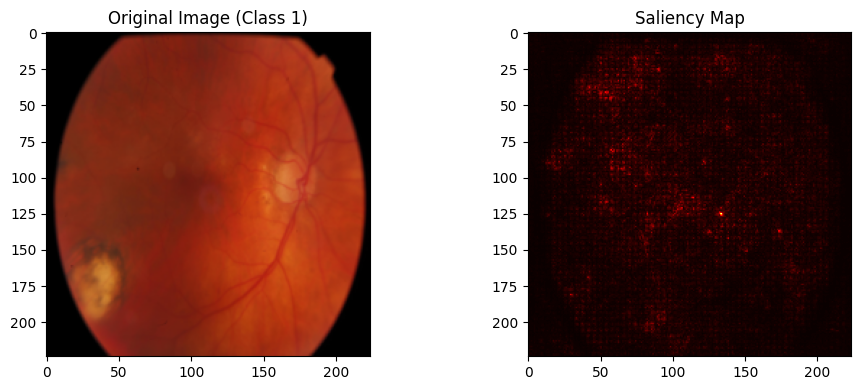

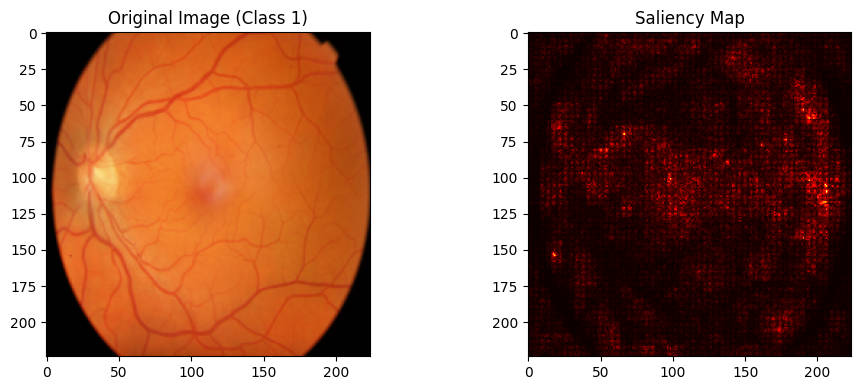

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)